In [1]:
import numpy as np

class StochasticEnv:

    def __init__(self, n_arms, sigma):
        self.n_arms = n_arms
        self.sigma = sigma
        self.reset(0)
        
    def step(self, action):
        return self.expected[action] + np.random.normal(0, self.sigma, 1)

    def reset(self, i_trials):
        self.expected = np.random.uniform(0, 1, self.n_arms)
    
    def get_exp_values(self):
        return self.expected

In [2]:
logplus = lambda x : np.log(np.maximum(1, x))

class UCBAgent:
    
    def __init__(self, n_arms, sigma, bound='ucb1', alpha=None, horizon=None):
        assert bound=='ucb1' or bound=='moss', 'error in upper confidence bound selection'
        if bound=='moss':
            assert horizon is not None, 'moss is not anytime, please select an horizon'
            self.horizon = horizon
        if bound=='ucb1':
            assert alpha is not None, 'ucb1 requires hyperparameter alpha'
            self.alpha = alpha
        self.n_arms = n_arms
        self.sigma = sigma
        self.bound = bound
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.avg_reward = np.zeros(self.n_arms)
        self.n_pulls = np.zeros(self.n_arms)
        return self

    def pull_arm(self):
        if self.bound=='ucb1':
            ucb = self.avg_reward + self.sigma * np.sqrt(
                       self.alpha * np.log(self.t) / self.n_pulls)
        if self.bound=='moss':    
            ucb = self.avg_reward + self.sigma * np.sqrt((4 / self.n_pulls) * logplus(
                       self.horizon / (self.n_arms * self.n_pulls))) 
        self.last_pull = np.argmax(ucb)
        return self.last_pull

    def update(self, reward):
        self.t += 1
        self.avg_reward[self.last_pull] = (self.avg_reward[self.last_pull] *
            self.n_pulls[self.last_pull] + reward) / (self.n_pulls[self.last_pull] + 1)
        self.n_pulls[self.last_pull] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_22684/1220251987.py:28: RuntimeWarning: invalid value encountered in true_divide
  self.alpha * np.log(self.t) / self.n_pulls)
/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_22684/1220251987.py:28: RuntimeWarning: divide by zero encountered in true_divide
  self.alpha * np.log(self.t) / self.n_pulls)


3.36$ & $7.61 \pm 0.23$ & $26.84$ & $27.01$ & $50.63 \pm 3.67$ & $216.09$ & $2.07$ & $4.73 \pm 0.17$ & $16.58$ & $9.96$ & $19.74 \pm 1.09$ & $79.65$ & $

  0%|          | 0/10 [00:00<?, ?it/s]

3.82$ & $8.71 \pm 0.17$ & $30.59$ & $30.79$ & $61.61 \pm 4.01$ & $246.3$ & $2.36$ & $5.45 \pm 0.11$ & $18.9$ & $11.35$ & $23.49 \pm 1.04$ & $90.78$ & $

  0%|          | 0/10 [00:00<?, ?it/s]

4.03$ & $8.93 \pm 0.18$ & $32.21$ & $32.41$ & $66.36 \pm 2.25$ & $259.31$ & $2.49$ & $5.63 \pm 0.11$ & $19.89$ & $11.95$ & $25.06 \pm 0.69$ & $95.58$ & $

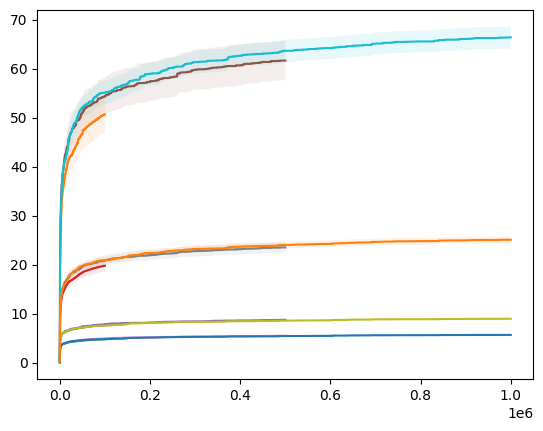

In [4]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
np.set_printoptions(formatter={'float': lambda x: "{0:0.02f}".format(x)})

horizons = [100000, 500000, 1000000]
n_trials = 10
sigma = 0.1
n_arms = 10
alpha = 4

env = StochasticEnv(n_arms, sigma)

for horizon in horizons:

    ucb1agent = UCBAgent(n_arms, sigma, bound='ucb1', alpha=alpha)
    mossagent = UCBAgent(n_arms, sigma, bound='moss', horizon=horizon)

    actions_ucb1 = np.zeros((n_trials, horizon))
    actions_moss = np.zeros((n_trials, horizon))

    expectedreward_ucb1 = np.zeros((n_trials, horizon))
    expectedreward_moss = np.zeros((n_trials, horizon))

    expectedregret_ucb1 = np.zeros((n_trials, horizon))
    expectedregret_moss = np.zeros((n_trials, horizon))

    # max_expected = np.zeros(n_trials)
    # expected = np.zeros((n_trials, n_arms))

    for sim_i in tqdm(range(n_trials)):

        # env.reset(sim_i)
        # expected[sim_i, :] = env.get_exp_values()
        expected = env.get_exp_values()
        ucb1agent.reset()
        mossagent.reset()

        for t in range(horizon):

            action = ucb1agent.pull_arm()
            reward = env.step(action)
            ucb1agent.update(reward)
            actions_ucb1[sim_i, t] = action
            expectedreward_ucb1[sim_i, t] = expected[action]

            '''
            action = mossagent.pull_arm()
            reward = env.step(action)
            mossagent.update(reward)
            actions_moss[sim_i, t] = action
            expectedreward_moss[sim_i, t] = expected[action]
            '''
            
    max_expected = max(expected)
    expectedregret_ucb1 = max_expected - expectedreward_ucb1
    # expectedregret_moss = max_expected - expectedreward_moss

    exp_ottima = lambda x : np.maximum(0, x - 0.1) 
    sqrtfun = lambda x : np.sqrt(x) 
    power2 = lambda x : np.power(x, 2) 
    identity = lambda x : x
    funcs = [exp_ottima, sqrtfun, power2, identity]

    aux1 = (alpha + 2) / (alpha - 2)
    aux2 = 2 * (alpha + 2) ** 2 / ((alpha - 2) ** 2 * np.log((alpha + 2) / 4))
    aux = aux1 + aux2

    for func in funcs:

        expectedregret_ucb1_g = func(expectedregret_ucb1)
        #expectedregret_moss_g = func(expectedregret_moss)

        cum_expectedregret_ucb1 = expectedregret_ucb1_g.cumsum(axis=1)
        #cum_expectedregret_moss = expectedregret_moss_g.cumsum(axis=1)

        cum_expectedregret_ucb1_mean = cum_expectedregret_ucb1.mean(axis=0)
        #cum_expectedregret_moss_mean = cum_expectedregret_moss.mean(axis=0)

        cum_expectedregret_ucb1_std = cum_expectedregret_ucb1.std(axis=0) / np.sqrt(n_trials)
        #cum_expectedregret_moss_std = cum_expectedregret_moss.std(axis=0) / np.sqrt(n_trials)

        plt.plot(cum_expectedregret_ucb1_mean.T, label='ucb1')
        plt.fill_between(np.linspace(0, horizon-1, horizon), 
                         cum_expectedregret_ucb1_mean - cum_expectedregret_ucb1_std,
                         cum_expectedregret_ucb1_mean + cum_expectedregret_ucb1_std, alpha=0.1)
        #plt.plot(cum_expectedregret_moss_mean.T, label='moss')
        #plt.fill_between(np.linspace(0, horizon-1, horizon), 
        #                 cum_expectedregret_moss_mean - cum_expectedregret_moss_std,
        #                 cum_expectedregret_moss_mean + cum_expectedregret_moss_std, alpha=0.1)
        #zplt.legend()

        vals_ub = np.zeros(n_arms)
        vals_lb = np.zeros(n_arms)
        for i in range(n_arms):
            if expected[i] != max_expected:
                delta = max_expected - expected[i]
                vals_ub[i] = np.log(horizon) * 4 * alpha *  (sigma ** 2) * func(delta) / (delta ** 2) # + func(delta) * aux
                vals_lb[i] = func(delta) / (delta ** 2)
        lb = np.log(horizon) * 2 * (sigma ** 2) * (np.sum(vals_lb))
        ub = np.sum(vals_ub)
        print(str(round(lb, 2)), end='$ & $')
        print(str(round(cum_expectedregret_ucb1_mean[-1], 2)) + ' \pm ' 
              + str(round(cum_expectedregret_ucb1_std[-1], 2)), end='$ & $')
        print(str(round(ub, 2)), end='$ & $')